# Ensemble Learning Lab: Bagging, AdaBoost, Random Forest

In [1]:
# Common imports and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier


def evaluate_model(clf, X_test, y_test, pos_label=1):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = None
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, pos_label]
        try:
            auc = roc_auc_score(y_test, y_proba)
        except Exception:
            auc = None
    return {"accuracy": acc, "roc_auc": auc}

# Dataset loading

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [3]:
len(y_train[y_train == 0]), len(y_train[y_train == 1])

(148, 250)

# Constants

In [24]:
max_depth = 7
random_state = 81

# Classifiers training

In [25]:
# Bagging example: compare single tree vs bagged trees
base = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
base.fit(X_train, y_train)

bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=max_depth),
    n_estimators=200,
    bootstrap=True,
    oob_score=True,
    random_state=random_state,
    n_jobs=-1
)

bag.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=7),
                  n_estimators=200, n_jobs=-1, oob_score=True, random_state=81)

In [26]:
# AdaBoost example
base_ada = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
base_ada.fit(X_train, y_train)

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=max_depth, random_state=random_state),
    n_estimators=200,
    learning_rate=1.0,
    random_state=0
)

ada.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=7,
                                                    random_state=81),
                   n_estimators=200, random_state=0)

In [27]:
# Random Forest example
rf = RandomForestClassifier(
    n_estimators=200,
    max_features="sqrt",
    bootstrap=True,
    oob_score=True,
    random_state=random_state,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=81)

# Model evaluations and comparisons

Train evals:
Base: {'accuracy': 1.0, 'roc_auc': np.float64(1.0)}
Bagging: {'accuracy': 1.0, 'roc_auc': np.float64(1.0)}
AdaBoost: {'accuracy': 1.0, 'roc_auc': np.float64(1.0)}
RandomForest: {'accuracy': 1.0, 'roc_auc': np.float64(1.0)}


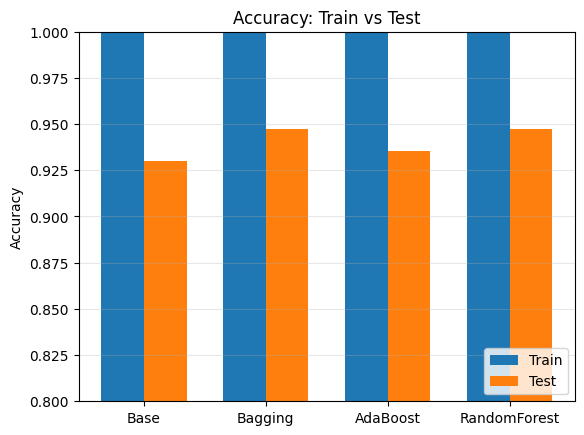

/tmp/ipython-input-284611783.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower right")


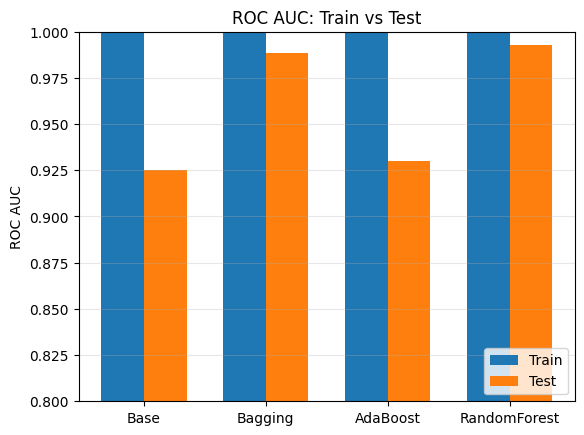

In [28]:
# Compute training-set evaluations for all models
base_train_eval = evaluate_model(base, X_train, y_train)
bag_train_eval = evaluate_model(bag, X_train, y_train)
ada_train_eval = evaluate_model(ada, X_train, y_train)
rf_train_eval = evaluate_model(rf, X_train, y_train)
base_test_eval = evaluate_model(base, X_test, y_test)
bag_test_eval = evaluate_model(bag, X_test, y_test)
ada_test_eval = evaluate_model(ada, X_test, y_test)
rf_test_eval = evaluate_model(rf, X_test, y_test)


print("Train evals:")
print("Base:", base_train_eval)
print("Bagging:", bag_train_eval)
print("AdaBoost:", ada_train_eval)
print("RandomForest:", rf_train_eval)
"""
Train vs Test Accuracy comparison plot
"""
models = ['Base', 'Bagging', 'AdaBoost', 'RandomForest']
train_acc = [base_train_eval['accuracy'], bag_train_eval['accuracy'], ada_train_eval['accuracy'], rf_train_eval['accuracy']]
test_acc = [base_test_eval['accuracy'], bag_test_eval['accuracy'], ada_test_eval['accuracy'], rf_test_eval['accuracy']]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, train_acc, width, label='Train')
ax.bar(x + width/2, test_acc, width, label='Test')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Accuracy')
ax.set_ylim(0.8, 1.0)
ax.set_title('Accuracy: Train vs Test')
ax.legend(loc="lower right")
ax.grid(True, axis='y', alpha=0.3)
plt.show()
"""
Train vs Test ROC AUC comparison plot
"""

train_auc = [
    base_train_eval['roc_auc'],
    bag_train_eval['roc_auc'],
    ada_train_eval['roc_auc'],
    rf_train_eval['roc_auc']
]

test_auc = [
    base_test_eval['roc_auc'],
    bag_test_eval['roc_auc'],
    ada_test_eval['roc_auc'],
    rf_test_eval['roc_auc']
]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
ax.legend(loc="lower right")

ax.bar(x - width/2, train_auc, width, label='Train')
ax.bar(x + width/2, test_auc, width, label='Test')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('ROC AUC')
ax.set_ylim(0.8, 1.0)
ax.set_title('ROC AUC: Train vs Test')
ax.grid(True, axis='y', alpha=0.3)
ax.legend(loc="lower right")
plt.show()

# Comparison as T grows

In [29]:
# Sweep n_estimators example (cross-validated) and plot results
import pandas as pd

def sweep_n_estimators(clf_builder, n_est_values, X, y, cv=5):
    results = []
    for n in n_est_values:
        clf = clf_builder(n)
        scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
        results.append((n, scores.mean(), scores.std()))
    return pd.DataFrame(results, columns=['n', 'mean_acc', 'std_acc'])

n_values = [1, 10,50,100,150, 200, 300, 400, 500]
res_rf = sweep_n_estimators(lambda n: RandomForestClassifier(n_estimators=n), n_values , X_train, y_train, cv=5)
res_ada = sweep_n_estimators(lambda n: AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=max_depth), n_estimators=n), n_values, X_train, y_train, cv=5)
res_bag = sweep_n_estimators(lambda n: BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=max_depth), n_estimators=n), n_values, X_train, y_train, cv=5)

Random Forests:
     n  mean_acc   std_acc
0    1  0.917057  0.029263
1   10  0.957342  0.012624
2   50  0.970000  0.034095
3  100  0.972500  0.032977
4  150  0.967500  0.038406
5  200  0.964968  0.031001
6  300  0.970000  0.034095
7  400  0.967468  0.032191
8  500  0.972500  0.032977
AdaBoost
     n  mean_acc   std_acc
0    1  0.919684  0.027896
1   10  0.937310  0.030464
2   50  0.924652  0.036308
3  100  0.929715  0.029084
4  150  0.924684  0.029449
5  200  0.932247  0.027934
6  300  0.929715  0.029084
7  400  0.934747  0.031923
8  500  0.929810  0.034824
Bagging
     n  mean_acc   std_acc
0    1  0.929747  0.031090
1   10  0.967437  0.029111
2   50  0.969968  0.031207
3  100  0.964937  0.029953
4  150  0.962468  0.036207
5  200  0.967468  0.032191
6  300  0.970000  0.034095
7  400  0.969968  0.031207
8  500  0.964937  0.029953


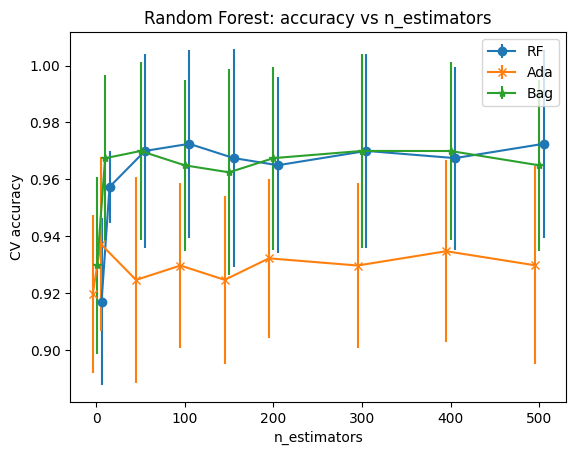

In [30]:

print("Random Forests:")
print(res_rf)

print("AdaBoost")
print(res_ada)

print("Bagging")
print(res_bag)

# Plot results, with error bars, error_bars should be affected by a little scattering for visibility
plt.errorbar(res_rf['n']+5, res_rf['mean_acc'], yerr=res_rf['std_acc'], marker='o', label="RF")
plt.errorbar(res_ada['n']-5, res_ada['mean_acc'], yerr=res_ada['std_acc'], marker='x', label="Ada")
plt.errorbar(res_bag['n'], res_bag['mean_acc'], yerr=res_bag['std_acc'], marker='*', label="Bag")

plt.xlabel('n_estimators')
plt.ylabel('CV accuracy')
plt.title('Random Forest: accuracy vs n_estimators')
plt.legend()
plt.show()